### Import necessary libraries

In [1]:
library(tidyverse)
library(dplyr)
library(modelr)
library(reshape2)
library(caret)
library(plotROC)
library(psych)
#library(MASS)

# temporarily suppress display warnings
options(warn=-1)
set.seed(23029)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift


Attaching package: ‘psych’

The following object is masked from ‘package:modelr’:

    heights

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



In [2]:
# set plot options
options(repr.plot.height=4.5, repr.matrix.max.rows=15)

### Read and Load Data

In [3]:
column_names = c("CAccountStatus","month","credHistory","purpose","credAmount","savingAcct","employedSince","installmentRate","personalStatusAndSex","debators","residenceSince","property","age","installmentPlans","housing","numOfExistingCredits","job","peopleLiableToMaintenance","telephone","foreignWorkers","outcome")
credit_raw = read_delim("german.data.txt", delim=" ",col_names=column_names)

Parsed with column specification:
cols(
  .default = col_character(),
  month = col_integer(),
  credAmount = col_integer(),
  installmentRate = col_integer(),
  residenceSince = col_integer(),
  age = col_integer(),
  numOfExistingCredits = col_integer(),
  peopleLiableToMaintenance = col_integer(),
  outcome = col_integer()
)
See spec(...) for full column specifications.


In [4]:
#converting boolean valued column into logical column
credit_raw =credit_raw %>% mutate(GoodRisk = outcome == 1 )
head(credit_raw)

CAccountStatus,month,credHistory,purpose,credAmount,savingAcct,employedSince,installmentRate,personalStatusAndSex,debators,⋯,age,installmentPlans,housing,numOfExistingCredits,job,peopleLiableToMaintenance,telephone,foreignWorkers,outcome,GoodRisk
A11,6,A34,A43,1169,A65,A75,4,A93,A101,⋯,67,A143,A152,2,A173,1,A192,A201,1,TRUE
A12,48,A32,A43,5951,A61,A73,2,A92,A101,⋯,22,A143,A152,1,A173,1,A191,A201,2,FALSE
A14,12,A34,A46,2096,A61,A74,2,A93,A101,⋯,49,A143,A152,1,A172,2,A191,A201,1,TRUE
A11,42,A32,A42,7882,A61,A74,2,A93,A103,⋯,45,A143,A153,1,A173,2,A191,A201,1,TRUE
A11,24,A33,A40,4870,A61,A73,3,A93,A101,⋯,53,A143,A153,2,A173,2,A191,A201,2,FALSE
A14,36,A32,A46,9055,A65,A73,2,A93,A101,⋯,35,A143,A153,1,A172,2,A192,A201,1,TRUE


In [5]:
## converting categorical data into factor and ordered factor

convert_to_factor = function(credit_raw) {
    credit_raw$CAccountStatus = factor(credit_raw$CAccountStatus,ordered=TRUE)
        
    credit_raw$credHistory = factor(credit_raw$credHistory)
        
    credit_raw$purpose = factor(credit_raw$purpose)
        
    credit_raw$savingAcct = factor(credit_raw$savingAcct,ordered=TRUE)
    
    credit_raw$employedSince = factor(credit_raw$employedSince,ordered=TRUE)
    
    credit_raw$personalStatusAndSex = factor(credit_raw$personalStatusAndSex)
    
    credit_raw$debators = factor(credit_raw$debators)
    
    credit_raw$property = factor(credit_raw$property)
    
    credit_raw$installmentPlans = factor(credit_raw$installmentPlans)
   
    credit_raw$housing = factor(credit_raw$housing)
    

    credit_raw$job = factor(credit_raw$job)
   

    credit_raw$telephone = factor(credit_raw$telephone)
    

    credit_raw$foreignWorkers = factor(credit_raw$foreignWorkers)
    


    credit_raw$employedSince = factor(credit_raw$employedSince)
    
    
    return (credit_raw)
}

In [6]:
credit_raw = convert_to_factor(credit_raw)


In [7]:
sapply(credit_raw, class)

$CAccountStatus
[1] "ordered" "factor" 

$month
[1] "integer"

$credHistory
[1] "factor"

$purpose
[1] "factor"

$credAmount
[1] "integer"

$savingAcct
[1] "ordered" "factor" 

$employedSince
[1] "ordered" "factor" 

$installmentRate
[1] "integer"

$personalStatusAndSex
[1] "factor"

$debators
[1] "factor"

$residenceSince
[1] "integer"

$property
[1] "factor"

$age
[1] "integer"

$installmentPlans
[1] "factor"

$housing
[1] "factor"

$numOfExistingCredits
[1] "integer"

$job
[1] "factor"

$peopleLiableToMaintenance
[1] "integer"

$telephone
[1] "factor"

$foreignWorkers
[1] "factor"

$outcome
[1] "integer"

$GoodRisk
[1] "logical"

## Preparing for Evaluation



## Split dataset into training , tune & test set

Train set is used only to train the models.
Test set is used to evalaute if the best trained model also performs better in the unseen data (test).

Steps:

1. Add a `id` column
2. Sample rows
3. anti-join to make train data



In [8]:
credit_raw_with_id = credit_raw %>% 
mutate(id=1:n())
head(credit_raw_with_id,5)

CAccountStatus,month,credHistory,purpose,credAmount,savingAcct,employedSince,installmentRate,personalStatusAndSex,debators,⋯,installmentPlans,housing,numOfExistingCredits,job,peopleLiableToMaintenance,telephone,foreignWorkers,outcome,GoodRisk,id
A11,6,A34,A43,1169,A65,A75,4,A93,A101,⋯,A143,A152,2,A173,1,A192,A201,1,TRUE,1
A12,48,A32,A43,5951,A61,A73,2,A92,A101,⋯,A143,A152,1,A173,1,A191,A201,2,FALSE,2
A14,12,A34,A46,2096,A61,A74,2,A93,A101,⋯,A143,A152,1,A172,2,A191,A201,1,TRUE,3
A11,42,A32,A42,7882,A61,A74,2,A93,A103,⋯,A143,A153,1,A173,2,A191,A201,1,TRUE,4
A11,24,A33,A40,4870,A61,A73,3,A93,A101,⋯,A143,A153,2,A173,2,A191,A201,2,FALSE,5


spilt 10% of dataset as test set

In [9]:
test_credit_raw = credit_raw_with_id %>% 
                sample_frac(0.1)
nrow(test_credit_raw)
head(test_credit_raw,5)

[1] 100

CAccountStatus,month,credHistory,purpose,credAmount,savingAcct,employedSince,installmentRate,personalStatusAndSex,debators,⋯,installmentPlans,housing,numOfExistingCredits,job,peopleLiableToMaintenance,telephone,foreignWorkers,outcome,GoodRisk,id
A13,6,A32,A40,709,A64,A72,2,A94,A101,⋯,A143,A152,1,A171,1,A191,A202,1,TRUE,141
A11,12,A32,A42,1620,A61,A73,2,A92,A102,⋯,A143,A152,1,A173,1,A191,A201,1,TRUE,442
A14,10,A32,A40,1597,A63,A73,3,A93,A101,⋯,A143,A151,1,A172,2,A191,A202,1,TRUE,414
A11,15,A32,A43,1053,A61,A72,4,A94,A101,⋯,A143,A152,1,A173,1,A191,A202,1,TRUE,408
A12,6,A32,A43,484,A61,A74,3,A94,A103,⋯,A141,A152,1,A172,1,A191,A201,1,TRUE,812


 Remaining 90% of dataset is defined as train set that are not test data

In [10]:
train_credit_raw = credit_raw_with_id %>% anti_join(select(test_credit_raw, id))
head(train_credit_raw,5)
nrow(train_credit_raw)



Joining, by = "id"


CAccountStatus,month,credHistory,purpose,credAmount,savingAcct,employedSince,installmentRate,personalStatusAndSex,debators,⋯,installmentPlans,housing,numOfExistingCredits,job,peopleLiableToMaintenance,telephone,foreignWorkers,outcome,GoodRisk,id
A12,45,A34,A41,4576,A62,A71,3,A93,A101,⋯,A143,A152,1,A173,1,A191,A201,1,TRUE,1000
A11,45,A32,A43,1845,A61,A73,4,A93,A101,⋯,A143,A153,1,A173,1,A192,A201,2,FALSE,999
A14,12,A32,A43,804,A61,A75,4,A93,A101,⋯,A143,A152,1,A173,1,A191,A201,1,TRUE,998
A11,30,A32,A41,3857,A61,A73,4,A91,A101,⋯,A143,A152,1,A174,1,A192,A201,1,TRUE,997
A14,12,A32,A42,1736,A61,A74,3,A92,A101,⋯,A143,A152,1,A172,1,A191,A201,1,TRUE,996


[1] 900

### Plots

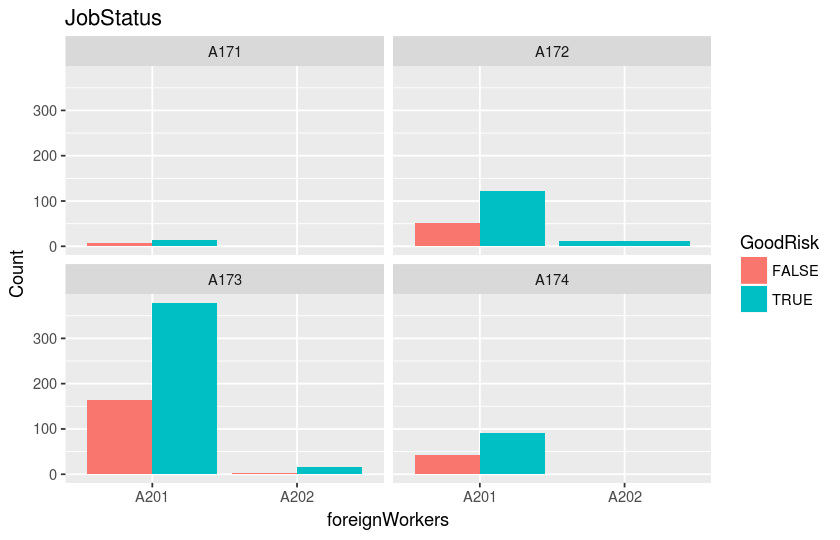

In [11]:


ggplot(train_credit_raw) +
    aes(x=foreignWorkers, fill = GoodRisk)+
    geom_bar(position=position_dodge()) +
    facet_wrap(~job)+
    ggtitle("JobStatus")+
    xlab("foreignWorkers")+
    ylab("Count")+
    labs(fill = "GoodRisk")

### Observation

Foreign workers who are skilled employee or official are the ones that should be given credit.

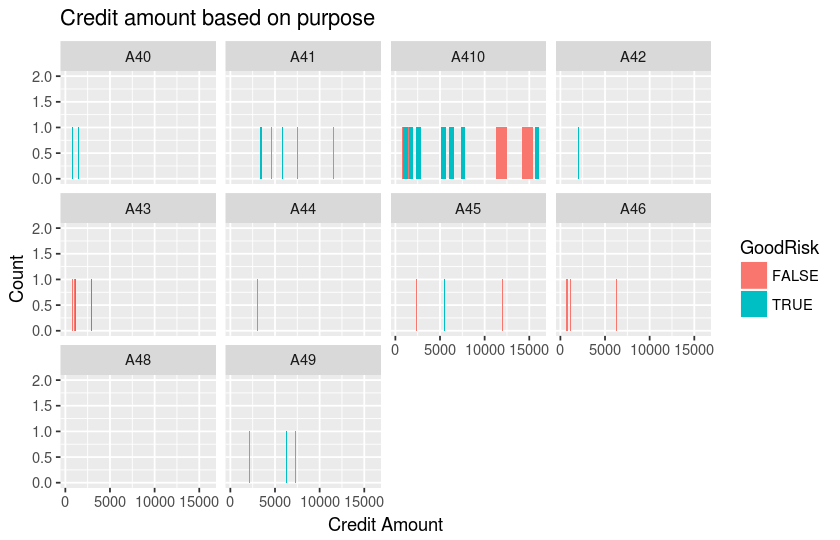

In [12]:
ggplot(train_credit_raw) +
    aes(x=credAmount, fill = GoodRisk)+
    geom_bar(position=position_dodge()) +
    facet_wrap(~purpose)+
    ggtitle("Credit amount based on purpose")+
    xlab("Credit Amount")+
    ylab("Count")+
    labs(fill = "GoodRisk")

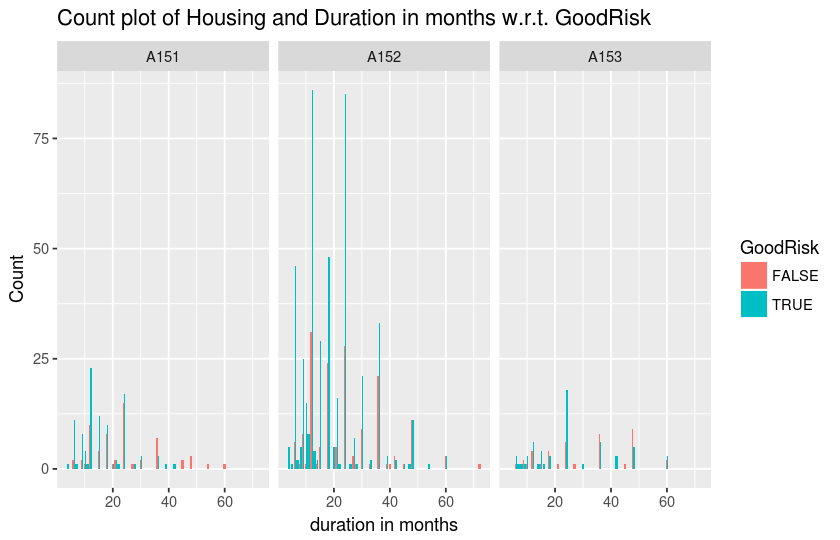

In [13]:
ggplot(train_credit_raw) +
    aes(x=month, fill = GoodRisk)+
    geom_bar(position=position_dodge()) +
    facet_wrap(~housing)+
    ggtitle("Count plot of Housing and Duration in months w.r.t. GoodRisk")+
    xlab("duration in months")+
    ylab("Count")+
    labs(fill = "GoodRisk")

It seems that people who either own their own house or live in rent are good candidates for credit.

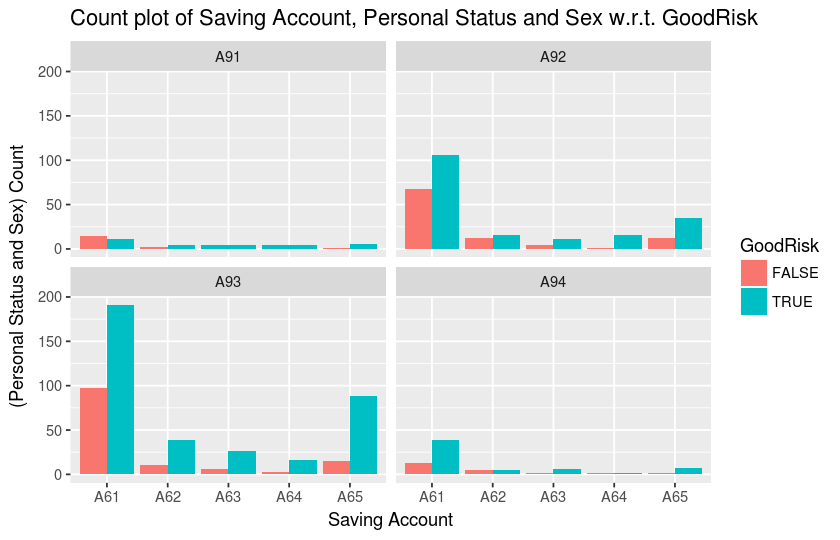

In [14]:
ggplot(train_credit_raw) +
    ggtitle("Count plot of Saving Account, Personal Status and Sex w.r.t. GoodRisk")+
    aes(x=savingAcct, fill = GoodRisk)+
    geom_bar(position=position_dodge()) +
    facet_wrap(~personalStatusAndSex)+
    xlab("Saving Account")+
    ylab("(Personal Status and Sex) Count")+
    labs(fill = "GoodRisk")

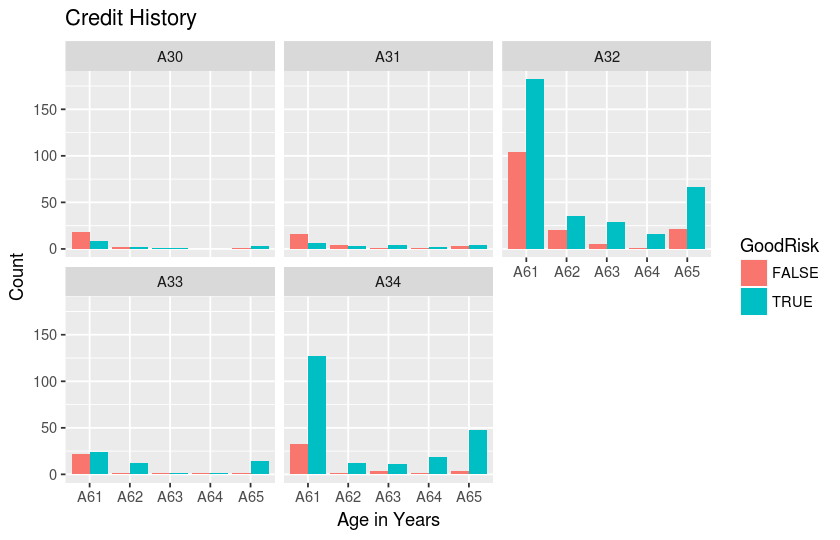

In [15]:
# Credit history over age
ggplot(train_credit_raw) +
    ggtitle("Credit History")+
    aes(x=savingAcct, fill = GoodRisk)+
    geom_bar(position=position_dodge()) +
    facet_wrap(~credHistory)+
    xlab("Age in Years")+
    ylab("Count")+
    labs(fill = "GoodRisk")

### Build Model

model_fitting method takes general linear model's parameters as glm_params and the training data source as data_tr.

In [16]:
## Base Methods

## Training
model_fitting = function(glm_params, data_tr) {
    trained_model = glm(glm_params, data=data_tr, family=binomial())
    return (trained_model)
}

## Test
compute_prediction = function(trained_model, data_test) {
    return (data_test %>% add_predictions(trained_model))
}

## Evaluation
## generating ROC using geom_roc that uses 2 aesthetics: d is the decision, m is the prediction estimate (numeric).
compute_roc = function(test_pred_this) {    
    full_roc_model_this = ggplot(test_pred_this) +
        aes(d=GoodRisk, m=pred) + 
        geom_roc()
    return (full_roc_model_this)
}

# sigmoid = function (x) {
#     return (1/(1+exp(-x)))
# }

# logit_threshold = function(sig) {
#     return (ifelse(sig > 0.5, 1, 0))
# }

#### Full Model 

model_full trains glm with all possible variables


Call:
glm(formula = glm_params, family = binomial(), data = data_tr)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6887  -0.6859   0.3589   0.6832   2.0782  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                1.709e+00  1.164e+00   1.468 0.142141    
CAccountStatus.L           1.192e+00  1.852e-01   6.436 1.22e-10 ***
CAccountStatus.Q           2.529e-01  2.309e-01   1.095 0.273300    
CAccountStatus.C          -6.308e-02  2.703e-01  -0.233 0.815464    
month                     -3.149e-02  9.913e-03  -3.177 0.001489 ** 
credHistoryA31            -4.943e-01  5.935e-01  -0.833 0.404977    
credHistoryA32             4.131e-01  4.537e-01   0.910 0.362573    
credHistoryA33             4.795e-01  4.895e-01   0.980 0.327288    
credHistoryA34             1.250e+00  4.633e-01   2.698 0.006982 ** 
purposeA41                 1.684e+00  3.889e-01   4.331 1.49e-05 ***
purposeA410                2.228e+00  9.53

PANEL,group,AUC
1,-1,0.7545582


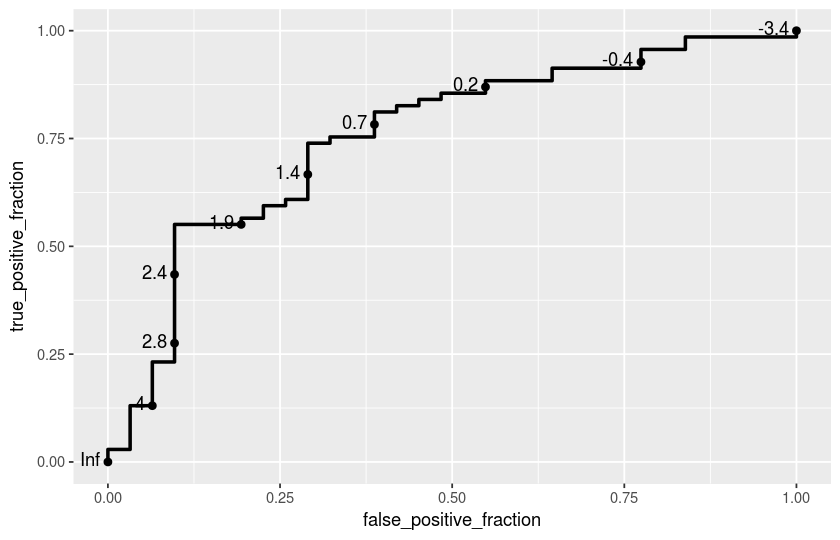

In [17]:
model_full_params = (GoodRisk ~. -GoodRisk -outcome -id)
model_full = model_fitting(model_full_params, train_credit_raw)
print(summary(model_full))
test_model_full = compute_prediction(model_full, test_credit_raw)

roc_m_full = compute_roc(test_model_full)
roc_m_full
calc_auc(roc_m_full)

In [18]:
library(MASS)
null = glm(GoodRisk ~ 1, data=train_credit_raw)
full = glm(model_full_params, data=train_credit_raw, family=binomial())
#step = stepAIC(glm(model_full_params, data=train_credit_raw, family=binomial()), trace = 1)
step = step(null, scope=list(lower=null, upper=full), direction="forward")
step$anova


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



Start:  AIC=1151.59
GoodRisk ~ 1

                            Df Deviance    AIC
+ CAccountStatus             3   166.43 1045.1
+ credHistory                4   177.50 1105.0
+ month                      1   179.26 1107.9
+ savingAcct                 4   182.32 1129.1
+ property                   3   183.05 1130.7
+ credAmount                 1   184.22 1132.5
+ purpose                    9   181.59 1135.5
+ employedSince              4   184.55 1140.1
+ housing                    2   185.45 1140.4
+ installmentPlans           2   186.27 1144.4
+ debators                   2   186.35 1144.8
+ age                        1   187.17 1146.7
+ foreignWorkers             1   187.29 1147.3
+ installmentRate            1   187.41 1147.9
+ personalStatusAndSex       3   187.08 1150.3
+ numOfExistingCredits       1   188.11 1151.2
<none>                           188.60 1151.6
+ telephone                  1   188.24 1151.9
+ peopleLiableToMaintenance  1   188.58 1153.5
+ residenceSince          

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
,NA,NA,899,188.5989,1151.5943
+ CAccountStatus,-3,22.1654359,896,166.4335,1045.0701
+ month,-1,7.2813086,895,159.1521,1006.8086
+ credHistory,-4,4.9263765,891,154.2258,986.5099
+ purpose,-9,6.2499142,882,147.9759,967.2783
+ debators,-2,2.5847531,880,145.3911,955.4187
+ savingAcct,-4,2.7485604,876,142.6425,946.2417
+ installmentRate,-1,0.8660526,875,141.7765,942.7607
⋮,⋮,⋮,⋮,⋮,⋮
+ credAmount,-1,0.7894196,871,139.5092,936.2513


## Feature Selection with Random forest

In [19]:
library(randomForest)

fit <- randomForest(GoodRisk ~ . -GoodRisk -outcome -id, data = train_credit_raw,family=binomial(), importance=TRUE)

print(fit)
print(varImp(fit))

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:psych’:

    outlier

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin




Call:
 randomForest(formula = GoodRisk ~ . - GoodRisk - outcome - id,      data = train_credit_raw, family = binomial(), importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 6

          Mean of squared residuals: 0.1603982
                    % Var explained: 23.46
                             Overall
CAccountStatus            35.7213445
month                     23.5452657
credHistory               13.2650184
purpose                   10.5213567
credAmount                14.2599628
savingAcct                10.2884693
employedSince              7.5947182
installmentRate            4.2643680
personalStatusAndSex       2.1106199
debators                   8.5728823
residenceSince             1.7234618
property                   5.6780745
age                        7.4136909
installmentPlans          11.3430982
housing                    2.8355121
numOfExistingCredits       2.9288887
job    

##### AIC is the relative quality of the statistical model for given data. A model with minimum AIC value has a good fit to the truth but should have few parameters. Thus, on the basis of both stepAIC and feature importance generated by Random Forest, we have to select simple model with less number of variables and minimum AIC. 

## Model 1
model_1 trains glm with some of the selected features


Call:
glm(formula = glm_params, family = binomial(), data = data_tr)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3984  -0.8449   0.4416   0.7723   2.0524  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -4.457e-01  5.683e-01  -0.784 0.432814    
CAccountStatus.L      1.305e+00  1.707e-01   7.645 2.08e-14 ***
CAccountStatus.Q      1.708e-01  2.119e-01   0.806 0.420065    
CAccountStatus.C      5.443e-02  2.493e-01   0.218 0.827144    
month                -3.751e-02  8.614e-03  -4.354 1.34e-05 ***
credHistoryA31       -1.124e-01  5.312e-01  -0.212 0.832492    
credHistoryA32        7.096e-01  4.084e-01   1.738 0.082293 .  
credHistoryA33        6.783e-01  4.643e-01   1.461 0.144030    
credHistoryA34        1.339e+00  4.326e-01   3.096 0.001959 ** 
credAmount           -4.447e-05  3.696e-05  -1.203 0.228871    
installmentPlansA142  2.569e-02  4.150e-01   0.062 0.950645    
installmentPlansA143  5.112e-01  

PANEL,group,AUC
1,-1,0.7671809


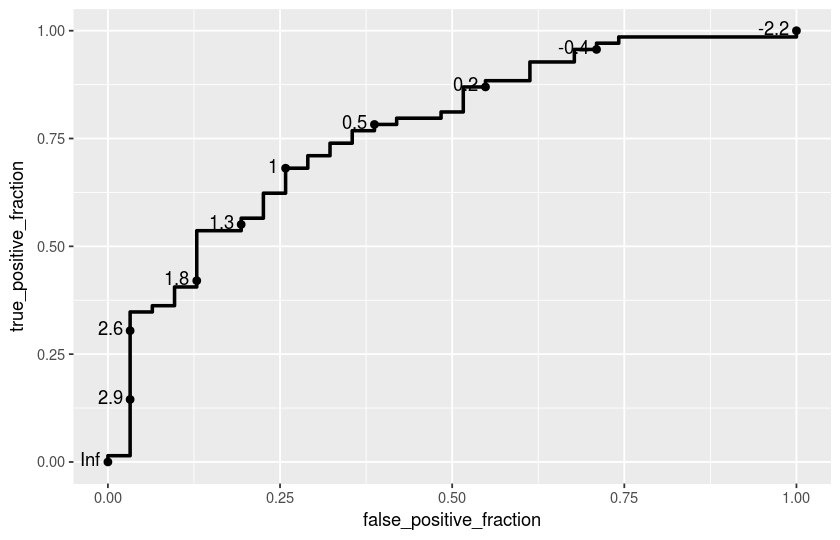

In [20]:
model_1 = model_fitting((GoodRisk ~ CAccountStatus + month + credHistory + credAmount +installmentPlans +
                         age+ purpose ),    
                        train_credit_raw)
print(summary(model_1))
test_model_1 = compute_prediction(model_1, test_credit_raw)

roc_m_1 = compute_roc(test_model_1)
roc_m_1
calc_auc(roc_m_1)

## Model  2
model_2 trains glm with some of the selected features


Call:
glm(formula = glm_params, family = binomial(), data = data_tr)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4596  -0.8357   0.4303   0.7530   2.0697  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -5.897e-01  5.728e-01  -1.029 0.303245    
CAccountStatus.L      1.341e+00  1.724e-01   7.776 7.50e-15 ***
CAccountStatus.Q      1.766e-01  2.130e-01   0.829 0.407077    
CAccountStatus.C      2.758e-03  2.515e-01   0.011 0.991250    
month                -3.772e-02  8.697e-03  -4.337 1.45e-05 ***
credHistoryA31       -9.267e-02  5.378e-01  -0.172 0.863195    
credHistoryA32        7.442e-01  4.090e-01   1.820 0.068797 .  
credHistoryA33        7.359e-01  4.646e-01   1.584 0.113158    
credHistoryA34        1.403e+00  4.344e-01   3.230 0.001239 ** 
credAmount           -3.474e-05  3.721e-05  -0.934 0.350526    
installmentPlansA142  8.107e-02  4.191e-01   0.193 0.846614    
installmentPlansA143  5.687e-01  

PANEL,group,AUC
1,-1,0.7568957


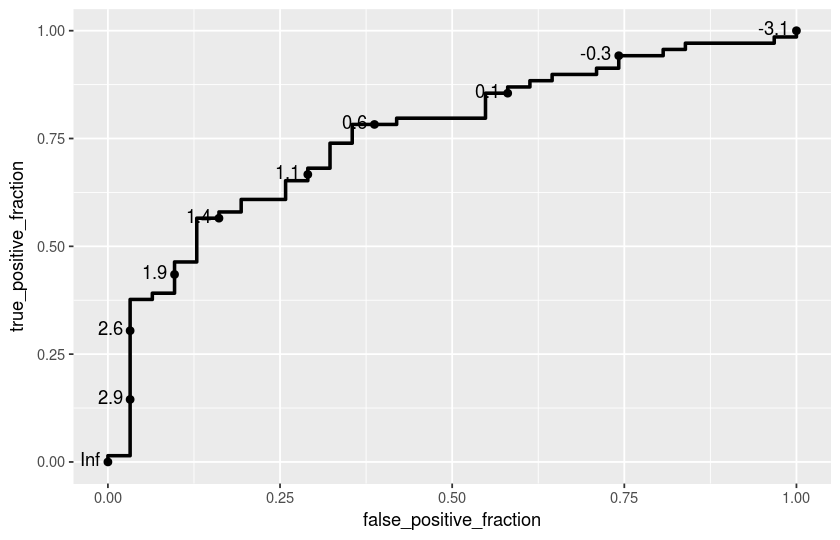

In [21]:
model_2 = model_fitting((GoodRisk ~ CAccountStatus + month + credHistory + credAmount +installmentPlans 
                         +age+ purpose + debators),
                        train_credit_raw)
print(summary(model_2))
test_model_2 = compute_prediction(model_2, test_credit_raw)

roc_m_2 = compute_roc(test_model_2)
roc_m_2
calc_auc(roc_m_2)

## Model 3
model_3 trains glm with some of the selected features


Call:
glm(formula = glm_params, family = binomial(), data = data_tr)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7340  -0.7871   0.4194   0.7402   2.0385  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.071e-01  5.956e-01  -0.180 0.857276    
CAccountStatus.L      1.248e+00  1.764e-01   7.070 1.54e-12 ***
CAccountStatus.Q      1.914e-01  2.170e-01   0.882 0.377621    
CAccountStatus.C     -1.167e-01  2.576e-01  -0.453 0.650483    
month                -3.989e-02  8.886e-03  -4.489 7.16e-06 ***
credHistoryA31       -2.971e-01  5.483e-01  -0.542 0.587930    
credHistoryA32        6.145e-01  4.136e-01   1.486 0.137316    
credHistoryA33        6.323e-01  4.676e-01   1.352 0.176309    
credHistoryA34        1.321e+00  4.396e-01   3.006 0.002646 ** 
credAmount           -3.684e-05  3.788e-05  -0.973 0.330779    
installmentPlansA142  1.053e-01  4.275e-01   0.246 0.805543    
installmentPlansA143  6.351e-01  

PANEL,group,AUC
1,-1,0.7480131


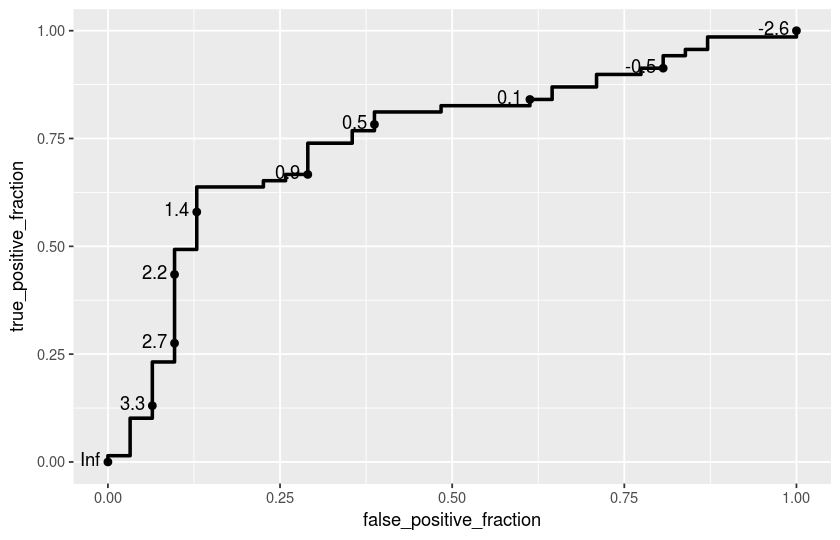

In [22]:
model_3 = model_fitting((GoodRisk ~ CAccountStatus + month + credHistory + credAmount +installmentPlans+age 
                         + purpose + debators + savingAcct ), train_credit_raw)
print(summary(model_3))
test_model_3 = compute_prediction(model_3, test_credit_raw)

roc_m_3 = compute_roc(test_model_3)
roc_m_3
calc_auc(roc_m_3)

## Model 4
model_4 trains glm with some of the selected features


Call:
glm(formula = glm_params, family = binomial(), data = data_tr)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6579  -0.7338   0.3927   0.7096   2.2754  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             1.647e+00  7.600e-01   2.166 0.030273 *  
CAccountStatus.L        1.257e+00  1.832e-01   6.860 6.87e-12 ***
CAccountStatus.Q        1.819e-01  2.207e-01   0.824 0.409957    
CAccountStatus.C       -1.307e-01  2.610e-01  -0.501 0.616477    
housingA152            -2.574e-01  5.371e-01  -0.479 0.631800    
housingA153            -7.016e-01  1.089e+00  -0.644 0.519369    
propertyA122           -1.352e+00  5.325e-01  -2.539 0.011113 *  
propertyA123           -9.206e-01  5.075e-01  -1.814 0.069695 .  
propertyA124           -1.067e+00  9.410e-01  -1.134 0.256645    
month                  -1.154e-01  2.880e-02  -4.006 6.18e-05 ***
credHistoryA31         -2.194e-01  5.756e-01  -0.381 0.703072    
credHisto

PANEL,group,AUC
1,-1,0.7582983


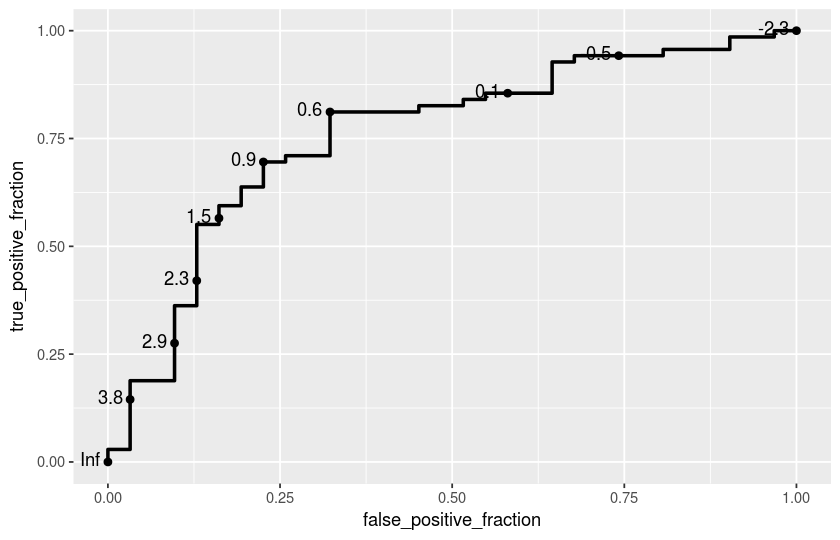

In [23]:
model_4 = model_fitting((GoodRisk ~ CAccountStatus + (housing + property) * month + credHistory + credAmount * purpose +installmentPlans 
                          + debators + savingAcct), train_credit_raw)
print(summary(model_4))
test_model_4 = compute_prediction(model_4, test_credit_raw)

roc_m_4 = compute_roc(test_model_4)
roc_m_4
calc_auc(roc_m_4)


### Model 5


Call:
glm(formula = glm_params, family = binomial(), data = data_tr)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6465  -0.7727   0.4158   0.7268   2.1606  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           5.442e-03  6.212e-01   0.009 0.993011    
CAccountStatus.L      1.230e+00  1.775e-01   6.929 4.23e-12 ***
CAccountStatus.Q      1.882e-01  2.177e-01   0.864 0.387397    
CAccountStatus.C     -1.206e-01  2.583e-01  -0.467 0.640496    
month                -3.682e-02  9.092e-03  -4.049 5.14e-05 ***
credHistoryA31       -2.747e-01  5.538e-01  -0.496 0.619906    
credHistoryA32        5.744e-01  4.151e-01   1.384 0.166477    
credHistoryA33        5.998e-01  4.696e-01   1.277 0.201491    
credHistoryA34        1.285e+00  4.404e-01   2.918 0.003523 ** 
credAmount           -2.729e-05  3.830e-05  -0.713 0.476111    
installmentPlansA142  2.762e-02  4.298e-01   0.064 0.948758    
installmentPlansA143  5.941e-01  

PANEL,group,AUC
1,-1,0.7447405


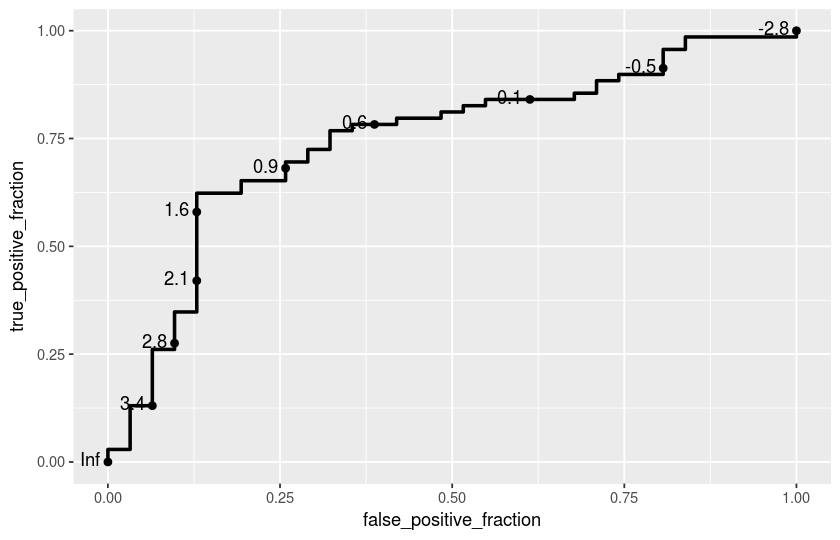

In [24]:
model_5 = model_fitting((GoodRisk ~ CAccountStatus + month + credHistory + credAmount +installmentPlans+age 
                         + purpose + debators + savingAcct+ property), train_credit_raw)
print(summary(model_5))
test_model_5 = compute_prediction(model_5, test_credit_raw)

roc_m_5 = compute_roc(test_model_5)
roc_m_5
calc_auc(roc_m_5)

## Observation from graph

From the ROC curve of the selected models, we can see that model_4 has the curve that is closer to
left-hand border and top border of the ROC space than other models. Also, the AUC value of model shows that the model is good enough as accuracy along with minimum AIC value with respect to other models.


### threshold
Computing threshold taking the range of values between minimum and maximum of predicted logits with the interval of 0.1

In [25]:
thresholds = seq(min(test_model_4$pred), max(test_model_4$pred), 0.1)
thresholds

[1] -2.27868354 -2.17868354 -2.07868354 -1.97868354 -1.87868354 -1.77868354
  [7] -1.67868354 -1.57868354 -1.47868354 -1.37868354 -1.27868354 -1.17868354
 [13] -1.07868354 -0.97868354 -0.87868354 -0.77868354 -0.67868354 -0.57868354
 [19] -0.47868354 -0.37868354 -0.27868354 -0.17868354 -0.07868354  0.02131646
 [25]  0.12131646  0.22131646  0.32131646  0.42131646  0.52131646  0.62131646
 [31]  0.72131646  0.82131646  0.92131646  1.02131646  1.12131646  1.22131646
 [37]  1.32131646  1.42131646  1.52131646  1.62131646  1.72131646  1.82131646
 [43]  1.92131646  2.02131646  2.12131646  2.22131646  2.32131646  2.42131646
 [49]  2.52131646  2.62131646  2.72131646  2.82131646  2.92131646  3.02131646
 [55]  3.12131646  3.22131646  3.32131646  3.42131646  3.52131646  3.62131646
 [61]  3.72131646  3.82131646  3.92131646  4.02131646  4.12131646  4.22131646
 [67]  4.32131646  4.42131646  4.52131646  4.62131646  4.72131646  4.82131646
 [73]  4.92131646  5.02131646  5.12131646  5.22131646  5.32131646  5.42131646
 [79]  5.52131646  5.62131646  5.72131646  5.82131646  5.92131646  6.02131646
 [85]  6.12131646  6.22131646  6.32131646  6.42131646  6.52131646  6.62131646
 [91]  6.72131646  6.82131646  6.92131646  7.02131646  7.12131646  7.22131646
 [97]  7.32131646  7.42131646  7.52131646  7.62131646  7.72131646  7.82131646
[103]  7.92131646  8.02131646  8.12131646  8.22131646  8.32131646  8.42131646
[109]  8.52131646  8.62131646  8.72131646  8.82131646  8.92131646  9.02131646
[115]  9.12131646  9.22131646  9.32131646  9.42131646  9.52131646  9.62131646
[121]  9.72131646  9.82131646  9.92131646 10.02131646 10.12131646 10.22131646
[127] 10.32131646 10.42131646 10.52131646 10.62131646 10.72131646 10.82131646
[133] 10.92131646 11.02131646 11.12131646 11.22131646 11.32131646 11.42131646
[139] 11.52131646 11.62131646 11.72131646 11.82131646 11.92131646 12.02131646
[145] 12.12131646 12.22131646 12.32131646 12.42131646 12.52131646 12.62131646
[151] 12.72131646 12.82131646 12.92131646 13.02131646 13.12131646 13.22131646
[157] 13.32131646 13.42131646 13.52131646 13.62131646 13.72131646 13.82131646
[163] 13.92131646 14.02131646 14.12131646 14.22131646 14.32131646 14.42131646
[169] 14.52131646 14.62131646 14.72131646 14.82131646 14.92131646 15.02131646
[175] 15.12131646 15.22131646 15.32131646 15.42131646 15.52131646 15.62131646
[181] 15.72131646 15.82131646 15.92131646 16.02131646

## Cost

1. convert the numeric score of predictions from the regression output into binary outcomes as TRUE or FALSE      by comparing with the threshold 
2. computing the cost of overall test set using each of these thresholds

In [26]:
costs = function(threshold) {
   
   test_model_4$sample_outcome = ifelse(test_model_4$pred > threshold, TRUE, FALSE)
   totalcosts= sum((test_model_4$GoodRisk == "TRUE" & test_model_4$sample_outcome == "FALSE") * 1,
                                    (test_model_4$GoodRisk==FALSE & test_model_4$sample_outcome==TRUE)*5)
       
    return(totalcosts)
   
}



In [27]:
totalcost=apply(data.frame(thresholds), 1, function(x){ costs(x)})
threshold_cost=data.frame(thresholds, totalcost)
head(threshold_cost)

thresholds,totalcost
-2.278684,150
-2.178684,150
-2.078684,150
-1.978684,151
-1.878684,151
-1.778684,141


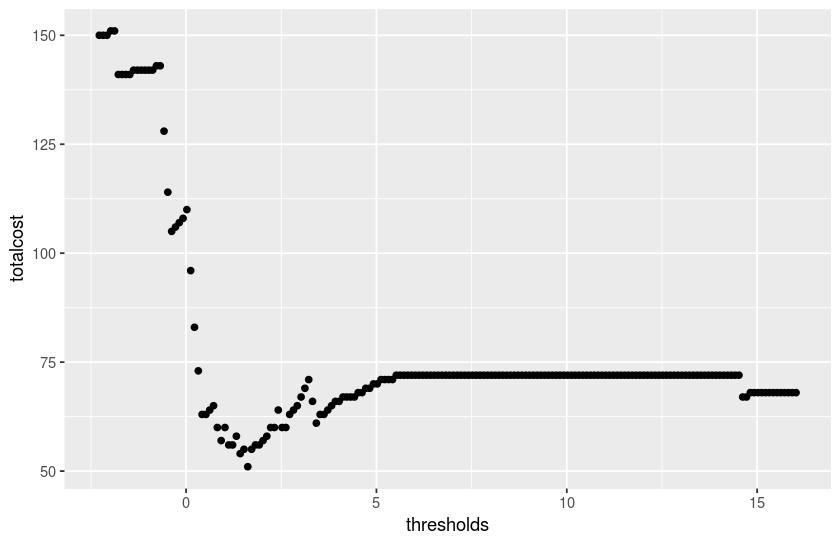

In [28]:
ggplot(threshold_cost) +
    aes(x=thresholds, y=totalcost) +
    geom_point()


finding the value of threshold having minimum cost.

In [29]:
threshold_mincost=filter(threshold_cost, totalcost==min(totalcost))
threshold_mincost

thresholds,totalcost
1.621316,51


There can be multiple thresholds giving minimum cost. Thus, we select first threshold as minimum threshold

In [30]:
selected_threshold=threshold_mincost$thresholds[1]
selected_threshold

[1] 1.621316

### calculate precision and recall

In [31]:
recall_precision=function(thresholds){
    dataf = dplyr::select(test_model_4, GoodRisk, pred)
    dataf$sample_outcome = ifelse(dataf$pred > thresholds, TRUE, FALSE)
    
    TP=sum(dataf$GoodRisk==TRUE & dataf$sample_outcome==TRUE)
    TN=sum(dataf$GoodRisk==FALSE & dataf$sample_outcome==FALSE)
    FP=sum(dataf$GoodRisk==FALSE & dataf$sample_outcome==TRUE)
    FN=sum(dataf$GoodRisk==TRUE & dataf$sample_outcome==FALSE)
    Recall=TP / sum(TP,FN)
    Precision=TP / sum(TP,FP) 
    PR=data.frame(Recall, Precision)
    return(PR)
    
}
recall_precision(selected_threshold)

Recall,Precision
0.5507246,0.9047619


Precision and recall for threshold that gives minimum cost and other two thresholds

In [32]:

th<-seq(selected_threshold-0.1,selected_threshold+0.1,0.1)
next_thresholds=apply(data.frame(th), 1, function(x){ recall_precision(x)})
P_R=data.frame(th, next_thresholds)
P_R


th,Recall,Precision,Recall.1,Precision.1,Recall.2,Precision.2
1.521316,0.5652174,0.8863636,0.5507246,0.9047619,0.4927536,0.8947368
1.621316,0.5652174,0.8863636,0.5507246,0.9047619,0.4927536,0.8947368
1.721316,0.5652174,0.8863636,0.5507246,0.9047619,0.4927536,0.8947368


## Direct Descrimination

protected features:
1. non single women
2. foreign workers

check the selected best model use the protected features? 


In [33]:
summary(model_4)


Call:
glm(formula = glm_params, family = binomial(), data = data_tr)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6579  -0.7338   0.3927   0.7096   2.2754  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             1.647e+00  7.600e-01   2.166 0.030273 *  
CAccountStatus.L        1.257e+00  1.832e-01   6.860 6.87e-12 ***
CAccountStatus.Q        1.819e-01  2.207e-01   0.824 0.409957    
CAccountStatus.C       -1.307e-01  2.610e-01  -0.501 0.616477    
housingA152            -2.574e-01  5.371e-01  -0.479 0.631800    
housingA153            -7.016e-01  1.089e+00  -0.644 0.519369    
propertyA122           -1.352e+00  5.325e-01  -2.539 0.011113 *  
propertyA123           -9.206e-01  5.075e-01  -1.814 0.069695 .  
propertyA124           -1.067e+00  9.410e-01  -1.134 0.256645    
month                  -1.154e-01  2.880e-02  -4.006 6.18e-05 ***
credHistoryA31         -2.194e-01  5.756e-01  -0.381 0.703072    
credHisto

Since the model doesnot use either of the protected features i.e foriegnworkers and  it has direct discrimination

## Indirect Discrimination

looking for correlations between the protected characteristic and the features used in selected best model i.e model_4 using chi-squared test

### chi-square test
Null Hypothesis: protected features are independent of other features of the model

Alternative Hypothesis: protected features are not independent of other features of the model

level of significance: 0.05

if p-value(>0.05) then we do not reject null hypothesis i.e protected features are independent of other features of the model.

### Correlation between Protected features and CAccountStatus

In [34]:
chi_Squared_test=function(other_features){
    contingency_table_foreignWorkers = table(credit_raw$foreignWorkers, other_features)
    print(contingency_table_foreignWorkers)
    chi_squared_foreignWorkers=chisq.test(contingency_table_foreignWorkers)
    print(chi_squared_foreignWorkers)
    
    
    contingency_table_nonSingleWomen = table(credit_raw$personalStatusAndSex=='A92', other_features)
    print(contingency_table_nonSingleWomen)
    chi_squared_nonSingleWomen=chisq.test(contingency_table_nonSingleWomen)
    return(chi_squared_nonSingleWomen)
    
    
    
    
}


In [35]:
chi_Squared_test(credit_raw$CAccountStatus)

      other_features
       A11 A12 A13 A14
  A201 259 264  59 381
  A202  15   5   4  13

	Pearson's Chi-squared test

data:  contingency_table_foreignWorkers
X-squared = 6.3991, df = 3, p-value = 0.09373

       other_features
        A11 A12 A13 A14
  FALSE 186 183  43 278
  TRUE   88  86  20 116



	Pearson's Chi-squared test

data:  contingency_table_nonSingleWomen
X-squared = 0.74188, df = 3, p-value = 0.8633


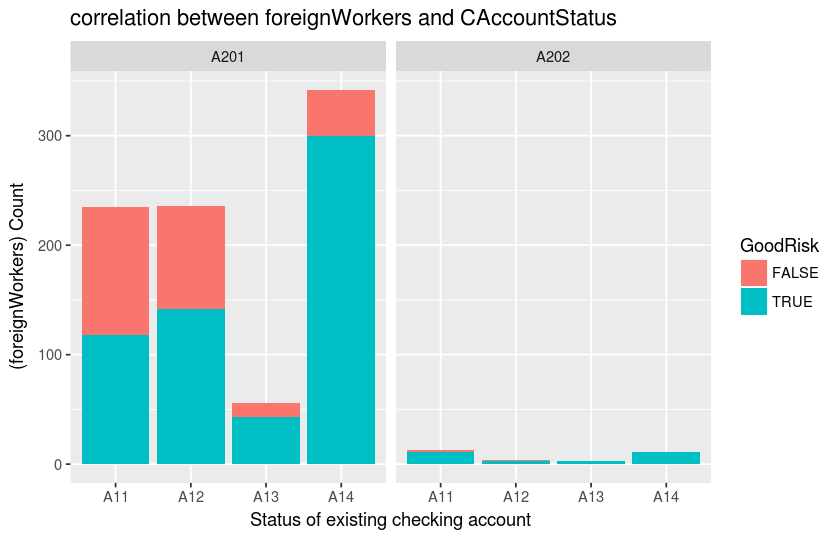

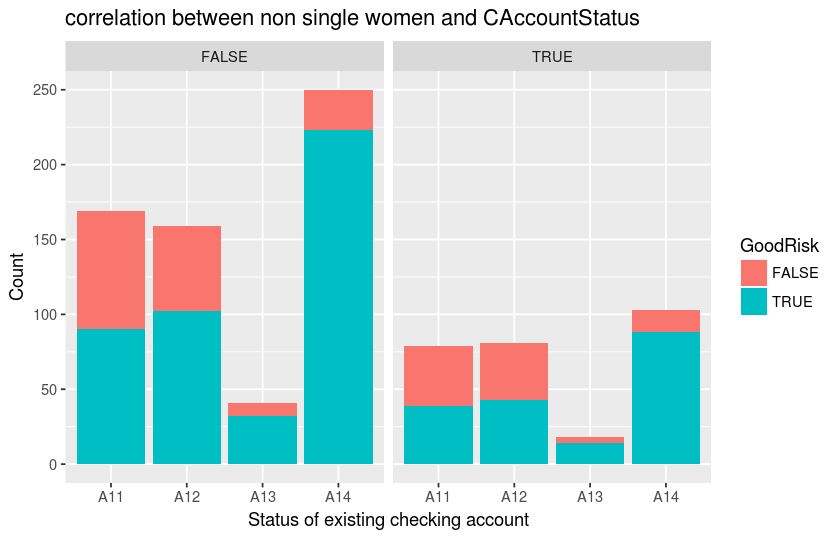

In [36]:
ggplot(train_credit_raw) +
    ggtitle("correlation between foreignWorkers and CAccountStatus")+
    aes(x=CAccountStatus, fill = GoodRisk)+
    geom_bar() +
    facet_wrap(~foreignWorkers)+
    xlab("Status of existing checking account")+
    ylab("(foreignWorkers) Count")+
    labs(fill = "GoodRisk")

ggplot(train_credit_raw) +
    ggtitle("correlation between non single women and CAccountStatus")+
    aes(x=CAccountStatus, fill = GoodRisk)+
    geom_bar() +
    facet_wrap(~personalStatusAndSex=='A92')+
    xlab("Status of existing checking account")+
    ylab("Count")+
    labs(fill = "GoodRisk")
    

#### Observation 

We apply the chisq.test function to the contingency table and found the p-value to be 0.09373 for foreignWorkers and 0.8633 for non single Women. 

We observed the p-value for foreignWorkers to be 0.09373 (> 0.05) and 0.8633 (> 0.05) for non single Women. For each of the cases, we do not have enough statistical evidence to reject the null hypothesis. That's why we state that both foreignWorkers and non single women are independent of the Status of existing checking account with a 0.05 level of significance.  

### Correlation between Protected features and Housing

      other_features
       A151 A152 A153
  A201  170  685  108
  A202    9   28    0

	Pearson's Chi-squared test

data:  contingency_table_foreignWorkers
X-squared = 5.1386, df = 2, p-value = 0.07659

       other_features
        A151 A152 A153
  FALSE   84  517   89
  TRUE    95  196   19



	Pearson's Chi-squared test

data:  contingency_table_nonSingleWomen
X-squared = 53.955, df = 2, p-value = 1.922e-12


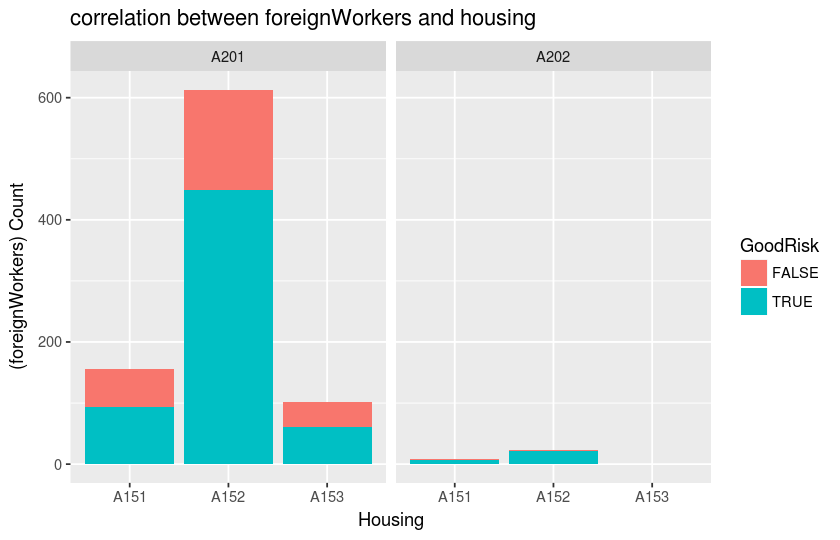

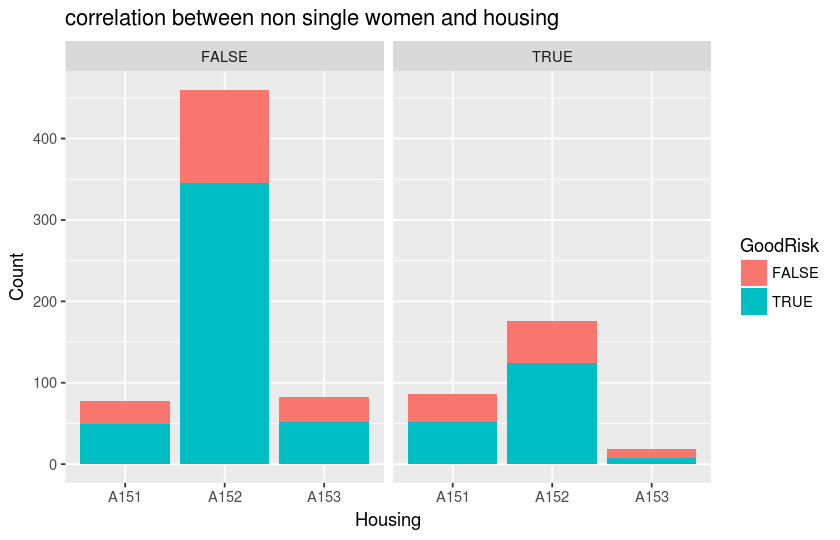

In [37]:
chi_Squared_test(credit_raw$housing)

ggplot(train_credit_raw) +
    ggtitle("correlation between foreignWorkers and housing")+
    aes(x=housing, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~foreignWorkers)+
    xlab("Housing")+
    ylab("(foreignWorkers) Count")
    

ggplot(train_credit_raw) +
    ggtitle("correlation between non single women and housing")+
    aes(x=housing, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~personalStatusAndSex=='A92')+
    xlab("Housing")+
    ylab("Count")
    

### Observation

We apply the chisq.test function to the contingency table and found the p-value to be 0.07659 for foreignWorkers and 1.922e-12 for non single Women. 

We observed the p-value for foreignWorkers to be 0.07659 (> 0.05) and 1.922e-12 (< 0.05) for non single Women. For foreignWorkers, we do not have enough statistical evidence to reject the null hypothesis but we can reject the null hypothesis for non single womens. That's why we state that the foreignWorkers is independent but non single womens is not independent of the housing with a 0.05 level of significance.


### Correlation between Protected features and Property


      other_features
       A121 A122 A123 A124
  A201  262  220  329  152
  A202   20   12    3    2

	Pearson's Chi-squared test

data:  contingency_table_foreignWorkers
X-squared = 20.297, df = 3, p-value = 0.0001473

       other_features
        A121 A122 A123 A124
  FALSE  193  153  223  121
  TRUE    89   79  109   33



	Pearson's Chi-squared test

data:  contingency_table_nonSingleWomen
X-squared = 8.1678, df = 3, p-value = 0.04267


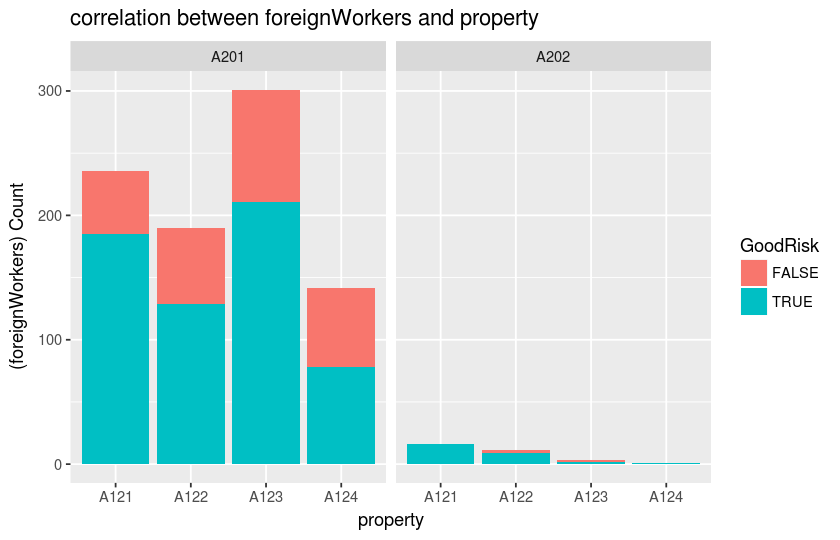

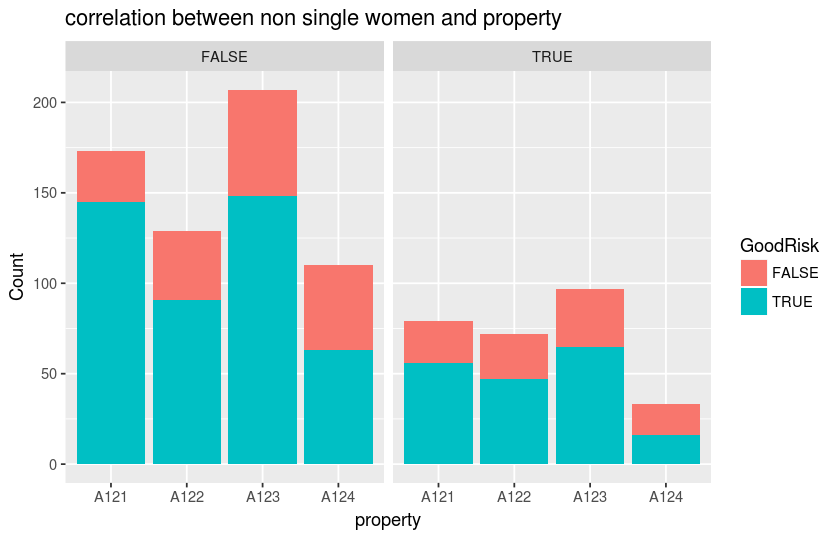

In [38]:
chi_Squared_test(credit_raw$property)


ggplot(train_credit_raw) +
    ggtitle("correlation between foreignWorkers and property")+
    aes(x=property, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~foreignWorkers)+
    xlab("property")+
    ylab("(foreignWorkers) Count")
    

ggplot(train_credit_raw) +
    ggtitle("correlation between non single women and property")+
    aes(x=property, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~personalStatusAndSex=='A92')+
    xlab("property")+
    ylab("Count")
   

### Observation

We apply the chisq.test function to the contingency table and found the p-value to be 0.0001473for foreignWorkers and 0.04267 for non single Women. 

We observed the p-value for foreignWorkers to be 0.0001473 (< 0.05) and 10.04267 (< 0.05) for non single Women. For each of the cases, we have enough statistical evidence to reject the null hypothesis. That's why we state that both foreignWorkers and non single womens are not independent of the property with a 0.05 level of significance.


### Correlation between Protected features and Credit History

      other_features
       A30 A31 A32 A33 A34
  A201  38  48 510  88 279
  A202   2   1  20   0  14

	Pearson's Chi-squared test

data:  contingency_table_foreignWorkers
X-squared = 4.9133, df = 4, p-value = 0.2963

       other_features
        A30 A31 A32 A33 A34
  FALSE  28  32 344  72 214
  TRUE   12  17 186  16  79



	Pearson's Chi-squared test

data:  contingency_table_nonSingleWomen
X-squared = 13.478, df = 4, p-value = 0.009163


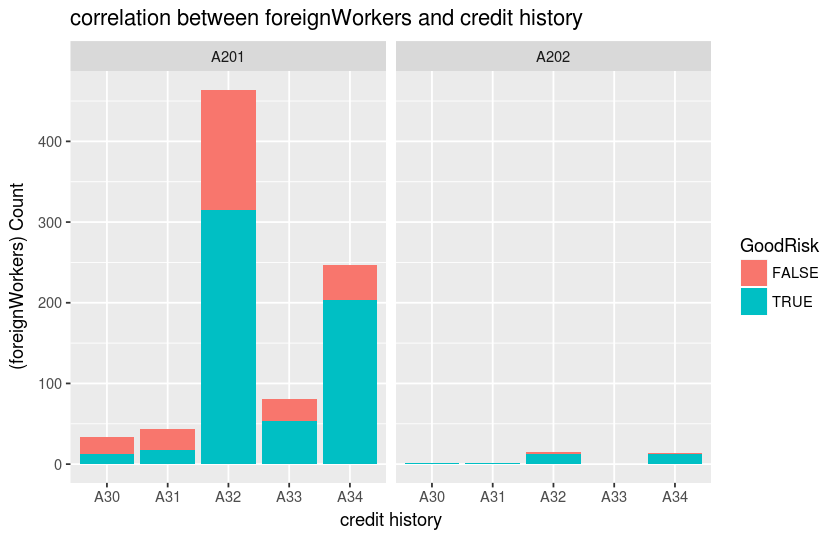

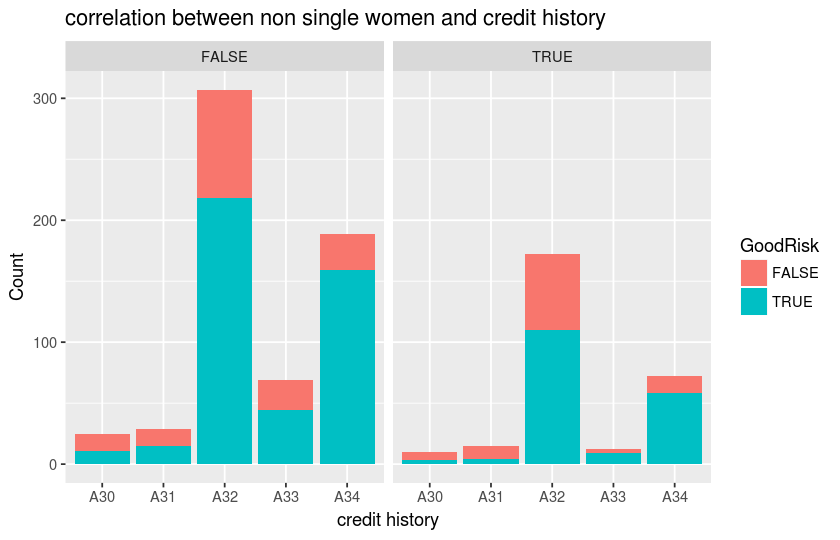

In [39]:
chi_Squared_test(credit_raw$credHistory)

ggplot(train_credit_raw) +
    ggtitle("correlation between foreignWorkers and credit history")+
    aes(x=credHistory, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~foreignWorkers)+
    xlab("credit history")+
    ylab("(foreignWorkers) Count")
    

ggplot(train_credit_raw) +
    ggtitle("correlation between non single women and credit history")+
    aes(x=credHistory, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~personalStatusAndSex=='A92')+
    xlab("credit history")+
    ylab("Count")

### Observation

We apply the chisq.test function to the contingency table and found the p-value to be 0.2963 for foreignWorkers and 0.009163 for non single Women. 


As the p-value for foreignWorkers 0.2963 > 0.05 significance level and 0.009163 < 0.05 significance level for non single Women, we do not reject the null hypothesis that the foreignWorkers is independent of credit history.But, we reject the null hypothesis that the non single women is not independent of the credit history.

### Correlation between Protected features and Purpose

      other_features
       A40 A41 A410 A42 A43 A44 A45 A46 A48 A49
  A201 213 101   11 175 275  12  21  50   9  96
  A202  21   2    1   6   5   0   1   0   0   1

	Pearson's Chi-squared test

data:  contingency_table_foreignWorkers
X-squared = 27.553, df = 9, p-value = 0.001133

       other_features
        A40 A41 A410 A42 A43 A44 A45 A46 A48 A49
  FALSE 164  79    9 107 195   6  17  29   6  78
  TRUE   70  24    3  74  85   6   5  21   3  19



	Pearson's Chi-squared test

data:  contingency_table_nonSingleWomen
X-squared = 22.993, df = 9, p-value = 0.006213


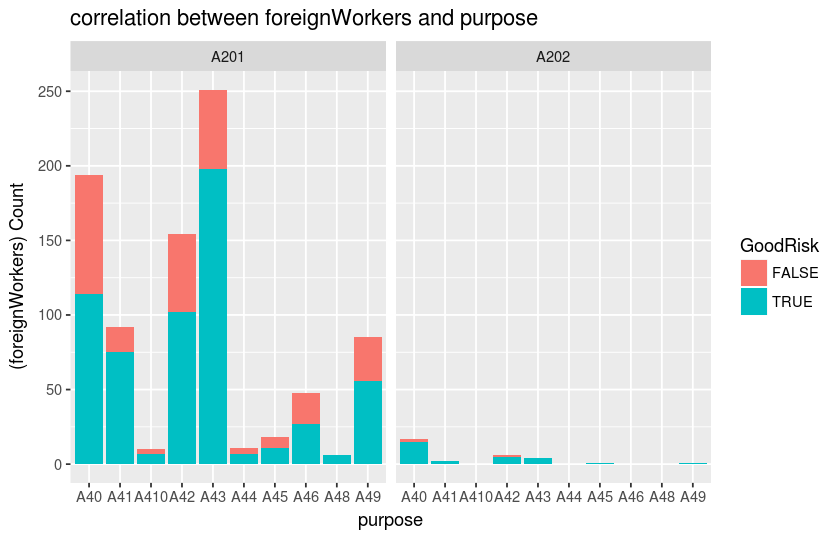

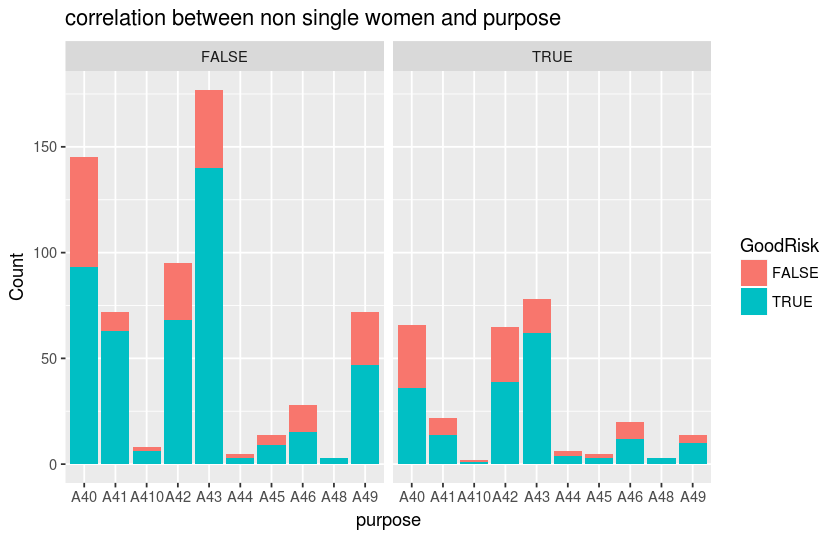

In [40]:
chi_Squared_test(credit_raw$purpose)

ggplot(train_credit_raw) +
    ggtitle("correlation between foreignWorkers and purpose")+
    aes(x=purpose, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~foreignWorkers)+
    xlab("purpose")+
    ylab("(foreignWorkers) Count")
    

ggplot(train_credit_raw) +
    ggtitle("correlation between non single women and purpose")+
    aes(x=purpose, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~personalStatusAndSex=='A92')+
    xlab("purpose")+
    ylab("Count")

### Observation

We apply the chisq.test function to the contingency table and found the p-value to be 0.001133 for foreignWorkers and 0.006213 for non single Women. 

We observed the p-value for foreignWorkers to be 0.001133 (< 0.05) and 0.006213 (< 0.05) for non single Women. For each of the cases, we have enough statistical evidence to reject the null hypothesis. That's why we state that both foreignWorkers and non single womens are not independent of the purpose with a 0.05 level of significance.


### Correlation between Protected features and Installment Plans

      other_features
       A141 A142 A143
  A201  134   47  782
  A202    5    0   32

	Pearson's Chi-squared test

data:  contingency_table_foreignWorkers
X-squared = 1.9321, df = 2, p-value = 0.3806

       other_features
        A141 A142 A143
  FALSE   99   37  554
  TRUE    40   10  260



	Pearson's Chi-squared test

data:  contingency_table_nonSingleWomen
X-squared = 2.7355, df = 2, p-value = 0.2547


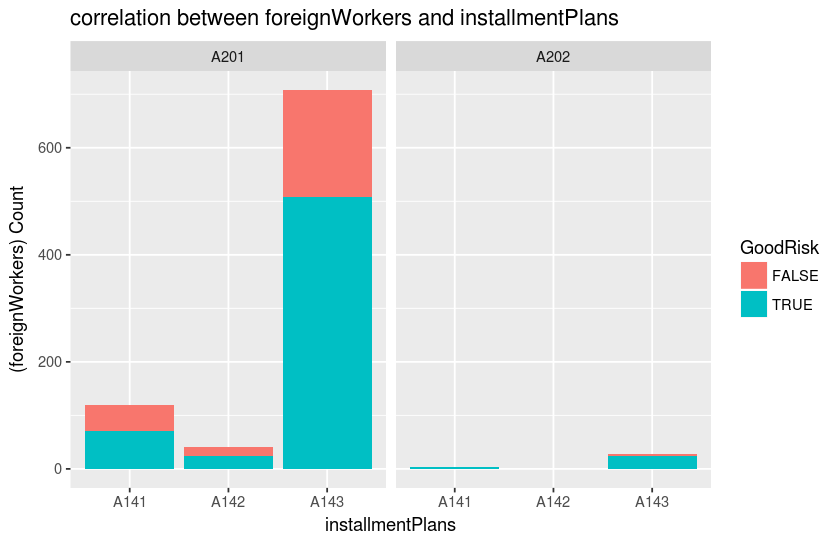

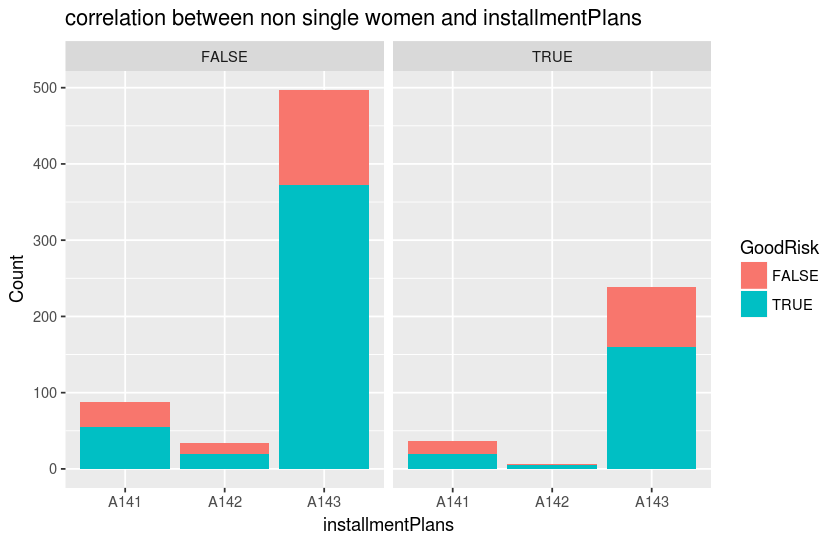

In [41]:
chi_Squared_test(credit_raw$installmentPlans)

ggplot(train_credit_raw) +
    ggtitle("correlation between foreignWorkers and installmentPlans")+
    aes(x=installmentPlans, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~foreignWorkers)+
    xlab("installmentPlans")+
    ylab("(foreignWorkers) Count")
    

ggplot(train_credit_raw) +
    ggtitle("correlation between non single women and installmentPlans")+
    aes(x=installmentPlans, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~personalStatusAndSex=='A92')+
    xlab("installmentPlans")+
    ylab("Count")

### Observation

We apply the chisq.test function to the contingency table and found the p-value to be 0.3806 for foreignWorkers and 0.2547 for non single Women. 

We observed the p-value for foreignWorkers to be 0.3806 (> 0.05) and 00.2547 (> 0.05) for non single Women. For each of the cases, we do not have enough statistical evidence to reject the null hypothesis. That's why we state that both foreignWorkers and non single womens are independent of the installment plans with a 0.05 level of significance.


### Correlation between Protected features and Debators

      other_features
       A101 A102 A103
  A201  880   37   46
  A202   27    4    6

	Pearson's Chi-squared test

data:  contingency_table_foreignWorkers
X-squared = 14.518, df = 2, p-value = 0.0007037

       other_features
        A101 A102 A103
  FALSE  624   29   37
  TRUE   283   12   15



	Pearson's Chi-squared test

data:  contingency_table_nonSingleWomen
X-squared = 0.18752, df = 2, p-value = 0.9105


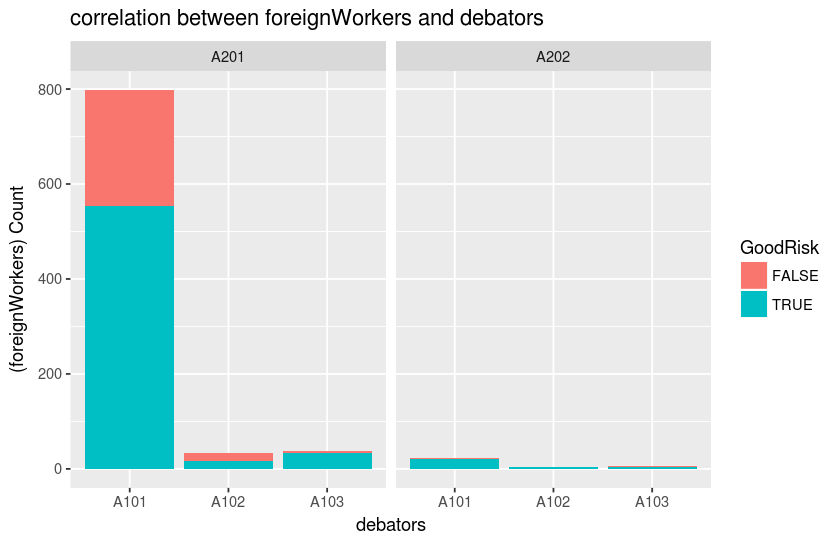

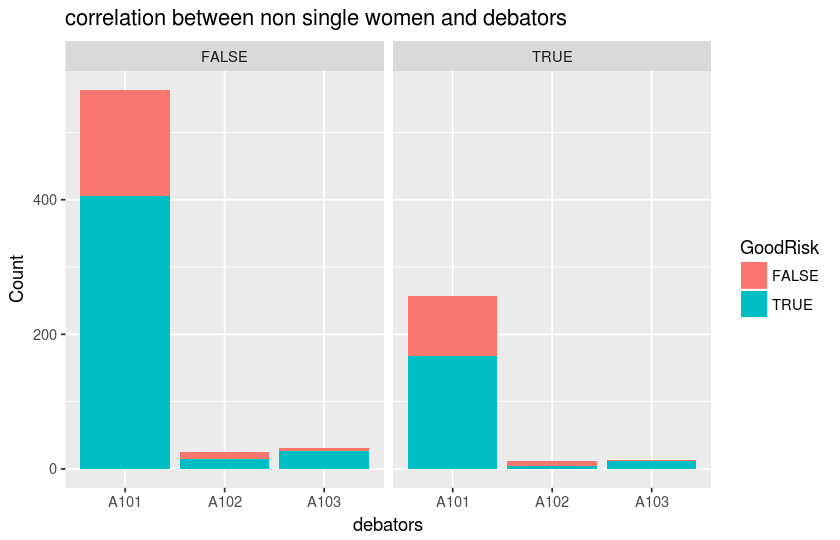

In [42]:
chi_Squared_test(credit_raw$debators)

ggplot(train_credit_raw) +
    ggtitle("correlation between foreignWorkers and debators")+
    aes(x=debators, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~foreignWorkers)+
    xlab("debators")+
    ylab("(foreignWorkers) Count")
    

ggplot(train_credit_raw) +
    ggtitle("correlation between non single women and debators")+
    aes(x=debators, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~personalStatusAndSex=='A92')+
    xlab("debators")+
    ylab("Count")

### Observation

We apply the chisq.test function to the contingency table and found the p-value to be 0.0007037 for foreignWorkers and 0.9105 for non single Women. 

We observed the p-value for foreignWorkers to be 0.0007037 (< 0.05) and 0.9105 (> 0.05) for non single Women. For foreignWorkers,we have enough statistical evidence to reject the null hypothesis but for non single womens, we do not have enough statistical evidence to reject the null hypothesis. That's why we state that the foreignWorkers is not independent but non single womens is independent of the debators with a 0.05 level of significance



### Correlation between Protected features and Saving Account

      other_features
       A61 A62 A63 A64 A65
  A201 581  99  62  45 176
  A202  22   4   1   3   7

	Pearson's Chi-squared test

data:  contingency_table_foreignWorkers
X-squared = 1.6875, df = 4, p-value = 0.793

       other_features
        A61 A62 A63 A64 A65
  FALSE 409  71  47  29 134
  TRUE  194  32  16  19  49



	Pearson's Chi-squared test

data:  contingency_table_nonSingleWomen
X-squared = 4.4922, df = 4, p-value = 0.3435


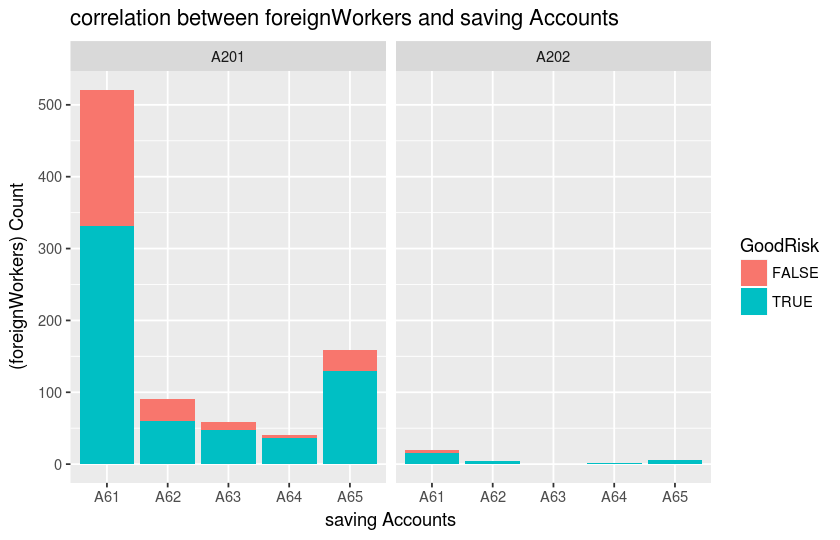

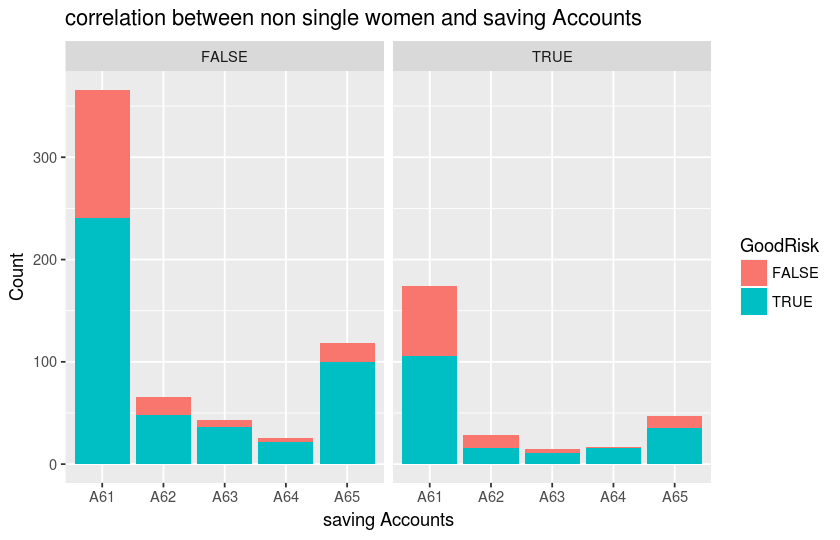

In [43]:
chi_Squared_test(credit_raw$savingAcct)

ggplot(train_credit_raw) +
    ggtitle("correlation between foreignWorkers and saving Accounts")+
    aes(x=savingAcct, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~foreignWorkers)+
    xlab("saving Accounts")+
    ylab("(foreignWorkers) Count")
    

ggplot(train_credit_raw) +
    ggtitle("correlation between non single women and saving Accounts")+
    aes(x=savingAcct, fill=GoodRisk)+
    geom_bar() +
    facet_wrap(~personalStatusAndSex=='A92')+
    xlab("saving Accounts")+
    ylab("Count")

### Observation

We apply the chisq.test function to the contingency table and found the p-value to be 0.793 for foreignWorkers and 0.3435 for non single Women. 

We observed the p-value for foreignWorkers to be 0.793 (> 0.05) and 0.3435 (> 0.05) for non single Women. For each of the cases, we do not have enough statistical evidence to reject the null hypothesis. That's why we state that both foreignWorkers and non single womens are independent of the saving accounts with a 0.05 level of significance.


###### Does it look like your model is indirectly discriminatory against members of our protected classes? Why or why not?

From the observation of the correlation between the protected features and other features that is used in our selected model, we found that the features i.e property and purpose have p-value less than 0.05 level of significance for both protected features(foreignWorkers and non single womens). For each cases, we have enough statistical evidence to reject the null hypothesis. That means both protected features are not  independent of property and purpose. The protected features have indirect effect in our model. Thus, we can state that our model is indirectly discriminatory against the members of protected features.

changing the cost weights i.e cost of false positive=3 from the evaluation section

In [44]:
thresholds = seq(min(test_model_4$pred), max(test_model_4$pred), 0.1)
thresholds

[1] -2.27868354 -2.17868354 -2.07868354 -1.97868354 -1.87868354 -1.77868354
  [7] -1.67868354 -1.57868354 -1.47868354 -1.37868354 -1.27868354 -1.17868354
 [13] -1.07868354 -0.97868354 -0.87868354 -0.77868354 -0.67868354 -0.57868354
 [19] -0.47868354 -0.37868354 -0.27868354 -0.17868354 -0.07868354  0.02131646
 [25]  0.12131646  0.22131646  0.32131646  0.42131646  0.52131646  0.62131646
 [31]  0.72131646  0.82131646  0.92131646  1.02131646  1.12131646  1.22131646
 [37]  1.32131646  1.42131646  1.52131646  1.62131646  1.72131646  1.82131646
 [43]  1.92131646  2.02131646  2.12131646  2.22131646  2.32131646  2.42131646
 [49]  2.52131646  2.62131646  2.72131646  2.82131646  2.92131646  3.02131646
 [55]  3.12131646  3.22131646  3.32131646  3.42131646  3.52131646  3.62131646
 [61]  3.72131646  3.82131646  3.92131646  4.02131646  4.12131646  4.22131646
 [67]  4.32131646  4.42131646  4.52131646  4.62131646  4.72131646  4.82131646
 [73]  4.92131646  5.02131646  5.12131646  5.22131646  5.32131646  5.42131646
 [79]  5.52131646  5.62131646  5.72131646  5.82131646  5.92131646  6.02131646
 [85]  6.12131646  6.22131646  6.32131646  6.42131646  6.52131646  6.62131646
 [91]  6.72131646  6.82131646  6.92131646  7.02131646  7.12131646  7.22131646
 [97]  7.32131646  7.42131646  7.52131646  7.62131646  7.72131646  7.82131646
[103]  7.92131646  8.02131646  8.12131646  8.22131646  8.32131646  8.42131646
[109]  8.52131646  8.62131646  8.72131646  8.82131646  8.92131646  9.02131646
[115]  9.12131646  9.22131646  9.32131646  9.42131646  9.52131646  9.62131646
[121]  9.72131646  9.82131646  9.92131646 10.02131646 10.12131646 10.22131646
[127] 10.32131646 10.42131646 10.52131646 10.62131646 10.72131646 10.82131646
[133] 10.92131646 11.02131646 11.12131646 11.22131646 11.32131646 11.42131646
[139] 11.52131646 11.62131646 11.72131646 11.82131646 11.92131646 12.02131646
[145] 12.12131646 12.22131646 12.32131646 12.42131646 12.52131646 12.62131646
[151] 12.72131646 12.82131646 12.92131646 13.02131646 13.12131646 13.22131646
[157] 13.32131646 13.42131646 13.52131646 13.62131646 13.72131646 13.82131646
[163] 13.92131646 14.02131646 14.12131646 14.22131646 14.32131646 14.42131646
[169] 14.52131646 14.62131646 14.72131646 14.82131646 14.92131646 15.02131646
[175] 15.12131646 15.22131646 15.32131646 15.42131646 15.52131646 15.62131646
[181] 15.72131646 15.82131646 15.92131646 16.02131646

In [45]:
costs = function(threshold) {   
   test_model_4$sample_outcome = ifelse(test_model_4$pred > threshold, TRUE, FALSE)
   totalcosts= sum((test_model_4$GoodRisk == "TRUE" & test_model_4$sample_outcome == "FALSE") * 1,
                                    (test_model_4$GoodRisk==FALSE & test_model_4$sample_outcome==TRUE)*3)       
    return(totalcosts)   
}

In [46]:
totalcost=apply(data.frame(thresholds), 1, function(x){ costs(x)})
threshold_cost=data.frame(thresholds, totalcost)
head(threshold_cost)

thresholds,totalcost
-2.278684,90
-2.178684,90
-2.078684,90
-1.978684,91
-1.878684,91
-1.778684,85


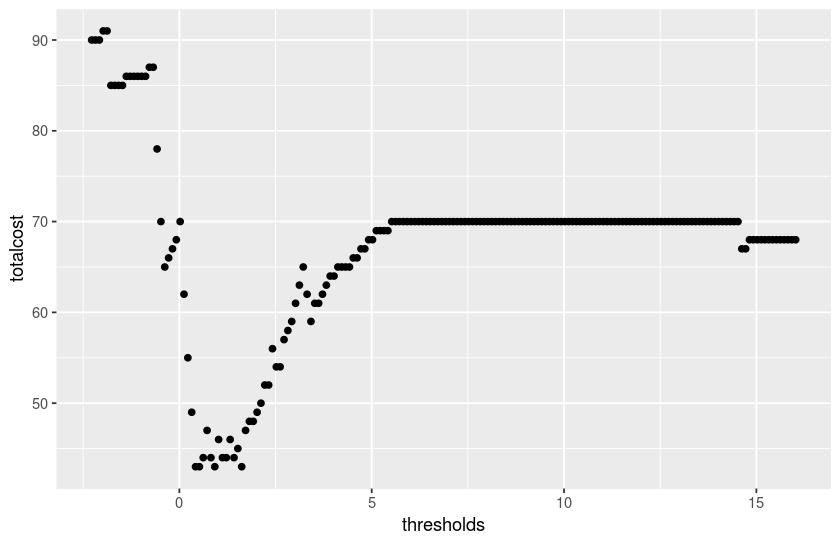

In [47]:
ggplot(threshold_cost) +
    aes(x=thresholds, y=totalcost) +
    geom_point()

In [48]:
threshold_mincost=filter(threshold_cost, totalcost==min(totalcost))
threshold_mincost

thresholds,totalcost
0.4213165,43
0.5213165,43
0.9213165,43
1.6213165,43


In [49]:
selected_threshold=threshold_mincost$thresholds[1]
selected_threshold

[1] 0.4213165

In [50]:
recall_precision=function(thresholds){
    dataf = dplyr::select(test_model_4, GoodRisk, pred)
    dataf$sample_outcome = ifelse(dataf$pred > thresholds, TRUE, FALSE)
    
    TP=sum(dataf$GoodRisk==TRUE & dataf$sample_outcome==TRUE)
    TN=sum(dataf$GoodRisk==FALSE & dataf$sample_outcome==FALSE)
    FP=sum(dataf$GoodRisk==FALSE & dataf$sample_outcome==TRUE)
    FN=sum(dataf$GoodRisk==TRUE & dataf$sample_outcome==FALSE)
    Recall=TP / sum(TP,FN)
    Precision=TP / sum(TP,FP) 
    PR=data.frame(Recall, Precision)
    return(PR)
    
}
recall_precision(selected_threshold)

Recall,Precision
0.8115942,0.8484848


#### observation
As we decrease the cost of false positive, we observed the value of recall increases as compared to the value we got from evaluation section. Thus, model gives better accuracy and less discriminatory.

## comparing best model and model with only protected features

Create train model 4 to train the model that uses the protected characteristics.

In [51]:
train_model_4 = compute_prediction(model_4, train_credit_raw)
#convert the model predicted value to TRUE FALSE based on the threshold value.
test_model_4$sample_outcome = ifelse(test_model_4$pred > selected_threshold, TRUE, FALSE)
train_model_4$sample_outcome = ifelse(train_model_4$pred > selected_threshold, TRUE, FALSE)

#Convert the protected features to 1 and rest to 0
test_model_4$personalStatusAndSex = ifelse(test_model_4$personalStatusAndSex=='A92',1,0)
train_model_4$personalStatusAndSex = ifelse(train_model_4$personalStatusAndSex=='A92',1,0)
test_model_4$foreignWorkers = ifelse(test_model_4$foreignWorkers=='A201',1,0)
train_model_4$foreignWorkers = ifelse(train_model_4$foreignWorkers=='A201',1,0)

test_model_4$sample_outcome

[1]  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE
 [13]  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE
 [25] FALSE  TRUE  TRUE  TRUE FALSE FALSE  TRUE  TRUE  TRUE FALSE  TRUE FALSE
 [37]  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE
 [49]  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [61] FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE  TRUE
 [73]  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE
 [85]  TRUE  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE
 [97]  TRUE FALSE FALSE  TRUE

In [52]:
#Create the train model with only protected features
train_modelWithOnlyProtectedFeatures = model_fitting(sample_outcome ~ personalStatusAndSex + foreignWorkers, train_model_4)

In [53]:
#generate test model with only protected features 
test__modelWithOnlyProtectedFeatures = compute_prediction(train_modelWithOnlyProtectedFeatures,test_model_4)

In [54]:
thresholds = seq(min(test__modelWithOnlyProtectedFeatures$pred), max(test__modelWithOnlyProtectedFeatures$pred), 0.1)

In [55]:
costs = function(threshold) {   
   test_model_4$sample_outcome = ifelse(test__modelWithOnlyProtectedFeatures$pred > threshold, TRUE, FALSE)
   totalcosts= sum((test__modelWithOnlyProtectedFeatures$GoodRisk == "TRUE" & test__modelWithOnlyProtectedFeatures$sample_outcome == "FALSE") * 1,
                  (test__modelWithOnlyProtectedFeatures$GoodRisk==FALSE & test__modelWithOnlyProtectedFeatures$sample_outcome==TRUE)*5)
       
    return(totalcosts)  
}

In [56]:
totalcost=apply(data.frame(thresholds), 1, function(x){ costs(x)})
threshold_cost=data.frame(thresholds, totalcost)

In [57]:
threshold_mincost=filter(threshold_cost, totalcost==min(totalcost))

In [58]:
selected_threshold=threshold_mincost$thresholds[1]
selected_threshold

[1] 0.5741551

In [59]:
test__modelWithOnlyProtectedFeatures$sample_outcome = ifelse(test__modelWithOnlyProtectedFeatures$pred > selected_threshold, TRUE, FALSE)
test__modelWithOnlyProtectedFeatures$sample_outcome

[1]  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE FALSE  TRUE
 [13]  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE
 [25]  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [37] FALSE  TRUE FALSE  TRUE FALSE FALSE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE
 [49]  TRUE  TRUE FALSE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE
 [61]  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE FALSE  TRUE FALSE  TRUE
 [73]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [85]  TRUE  TRUE  TRUE FALSE  TRUE  TRUE FALSE FALSE  TRUE FALSE  TRUE  TRUE
 [97]  TRUE FALSE FALSE  TRUE

In [60]:
#calculate the number of rows for which both models have the same predicitons
x=ifelse(test_model_4$sample_outcome==test__modelWithOnlyProtectedFeatures$sample_outcome,TRUE,FALSE)
temp=data.frame(x)
length(temp[temp[1]==TRUE,])

[1] 64

This shows that 51% of the main model output is predicted by the model with protected characteristics only. So, it 51% indirectly discriminatory

In [61]:
#Lets subtract the main model predicted value with the value predicted by the model with protected characteristics
head(test_model_4$pred)
head(test__modelWithOnlyProtectedFeatures$pred,5)
residuals_both_models = data.frame(test_model_4$pred,test__modelWithOnlyProtectedFeatures$pred)
residuals_both_models

[1]  3.1758025 -0.3294931  1.4207086  0.6899308  2.3920710  0.6874689

[1] 1.9637227 0.5741551 1.9637227 1.9637227 0.8335199

test_model_4.pred,test__modelWithOnlyProtectedFeatures.pred
3.17580247,1.9637227
-0.32949314,0.5741551
1.42070858,1.9637227
0.68993084,1.9637227
2.39207100,0.8335199
0.68746887,0.8335199
0.07598446,0.8335199
-0.80484369,0.5741551
⋮,⋮
0.94079065,0.5741551


In [62]:
test_model_4_error = test_model_4 %>%
                     add_residuals(train_modelWithOnlyProtectedFeatures)
test_model_4_error$resid

[1] -0.9637227 -0.5741551 -0.9637227 -0.9637227  0.1664801  0.1664801
  [7] -0.8335199 -0.5741551  0.1664801  0.4258449  0.4258449  0.1664801
 [13]  0.1664801  0.4258449 -0.8335199  0.1664801  0.1664801 -0.5741551
 [19]  0.1664801  0.1664801  0.1664801  0.4258449 -0.8335199  0.1664801
 [25] -0.8335199  0.4258449  0.1664801  0.4258449 -0.8335199 -0.8335199
 [31]  0.1664801  0.1664801  0.1664801 -0.8335199  0.1664801 -1.9637227
 [37]  0.4258449 -0.8335199  0.4258449  0.1664801  0.4258449  0.4258449
 [43] -0.8335199  0.1664801 -0.5741551  0.1664801  0.1664801  0.1664801
 [49]  0.1664801  0.1664801 -0.5741551  0.4258449 -0.9637227 -0.8335199
 [55]  0.4258449  0.1664801  0.4258449  0.1664801  0.1664801  0.1664801
 [61] -0.8335199  0.1664801 -0.8335199  0.1664801  0.1664801 -0.5741551
 [67]  0.4258449  0.1664801 -0.5741551 -0.8335199 -0.5741551  0.1664801
 [73]  0.1664801  0.1664801 -1.7043579  0.1664801  0.1664801  0.1664801
 [79]  0.1664801  0.1664801  0.1664801 -0.8335199 -0.8335199  0.1664801
 [85]  0.1664801  0.1664801 -0.8335199 -0.5741551  0.1664801 -0.8335199
 [91] -0.5741551 -0.5741551 -0.8335199  0.4258449  0.1664801 -0.8335199
 [97]  0.1664801 -0.5741551 -0.5741551  0.1664801

In [63]:
#now we try to predict the residual of the best model with the model of protected characteristics.
model_Error = glm (resid ~ personalStatusAndSex + foreignWorkers, test_model_4_error, family=gaussian())
summary(model_Error)
errorPrediction = test_model_4_error %>%
add_residuals(model_Error)
head(errorPrediction)


Call:
glm(formula = resid ~ personalStatusAndSex + foreignWorkers, 
    family = gaussian(), data = test_model_4_error)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7197  -0.5179   0.2803   0.2803   0.4821  

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -1.2634     0.1935  -6.531 3.01e-09 ***
personalStatusAndSex   0.0576     0.1042   0.552    0.582    
foreignWorkers         1.1496     0.1992   5.771 9.43e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2227368)

    Null deviance: 29.225  on 99  degrees of freedom
Residual deviance: 21.605  on 97  degrees of freedom
AIC: 138.57

Number of Fisher Scoring iterations: 2


CAccountStatus,month,credHistory,purpose,credAmount,savingAcct,employedSince,installmentRate,personalStatusAndSex,debators,⋯,job,peopleLiableToMaintenance,telephone,foreignWorkers,outcome,GoodRisk,id,pred,sample_outcome,resid
A13,6,A32,A40,709,A64,A72,2,0,A101,⋯,A171,1,A191,0,1,TRUE,141,3.1758025,TRUE,0.2997058
A11,12,A32,A42,1620,A61,A73,2,1,A102,⋯,A173,1,A191,1,1,TRUE,442,-0.3294931,FALSE,-0.5179097
A14,10,A32,A40,1597,A63,A73,3,0,A101,⋯,A172,2,A191,0,1,TRUE,414,1.4207086,TRUE,0.2997058
A11,15,A32,A43,1053,A61,A72,4,0,A101,⋯,A173,1,A191,0,1,TRUE,408,0.6899308,TRUE,0.2997058
A12,6,A32,A43,484,A61,A74,3,0,A103,⋯,A172,1,A191,1,1,TRUE,812,2.3920710,TRUE,0.2803253
A12,12,A34,A40,3124,A61,A72,1,0,A101,⋯,A172,2,A191,1,1,TRUE,582,0.6874689,TRUE,0.2803253


Let's check correlation between the residuals of the models

In [64]:
contingency_table = table(test_model_4_error$resid, errorPrediction$resid)
contingency_table
chisq.test(contingency_table)

                    
                     -0.719674684201421 -0.700294168541278 -0.5179096729538
  -1.9637227029474                    0                  1                0
  -1.70435787802418                   0                  0                0
  -0.963722702947396                  0                  0                0
  -0.833519921634323                 19                  0                0
  -0.57415509671111                   0                  0               13
  0.166480078365677                   0                  0                0
  0.42584490328889                    0                  0                0
                    
                     -0.498529157293658 0.280325315798579 0.299705831458722
  -1.9637227029474                    0                 0                 0
  -1.70435787802418                   1                 0                 0
  -0.963722702947396                  0                 0                 4
  -0.833519921634323                  0       


	Pearson's Chi-squared test

data:  contingency_table
X-squared = 600, df = 36, p-value < 2.2e-16


The p-value is smaller than 0.05 level of significance. so it seems like there is  indirect discrimination

### Limitations

- Accuracy of ground truth:
    - We are building our model assuming that the ground truth is accurate but we could not find much explanation regarding the dataset like how the dataset was collected. So, it is quite difficult to state whether the ground truth is accurate or inaccurate.

- Analysis of our model based on accurate/inaccurate ground truth:         
    - Since our model is supervised learning model, the model is manually taught the differences between good risk and bad risk. The accuracy of the prediction of the model depends on the ground truth of the dataset used to train the model. Thus, inaccuracies in the ground truth will directly correlates the inaccuracies in the resulting good risk or bad risk prediction of the model.
    
- Analysis of the model against historically-discriminatory process:
    - If the training data (ground truth) had followed the discriminatory process during the dataset collection or preparation, then our trained model is more likely to show bias towards the variables that were historically involved in the discrimination process. This also means that our model directly or indirectly use such variables. Our attempt to evaluate such variables being discriminatory should show direct/indirect association with the GoodRisk variable like we discussed in our evaluation of direct and indirect discriminatory section above.
    
- Analysis of the model against the attempts to detect unjust, illegal or unwanted discrimination:
    - The article https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing states how minority group like "black people' are affected by the unjust discrimination of the model used in court that predicts the likelihood of each committing a future crime. Similarly, the model built on the basis of data collected through historically discriminatory process is likely to have unjust or unwanted discrimination if applied in future real world. Since, the model is trained in small number of data, it may not predict accurately in case of all population in real world. For Example, what if our model takes only 20 percent to make prediction? then our model may state the person unillegible for the credit though he is actually illegible. 

### Appendix

1. After loading the library MASS used for stepAIC, the select method gives error since this library overrides the method select.
2. Since the value keeps on changing each time we run the code, some observation may differ. we have kept values according to what we got during coding.